In [1]:
# import library termasuk spacy, gensim, re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import string
import gensim
import operator
import re

In [4]:
df_movies = pd.read_csv('movies.csv') # file database saya letakan lokal


In [6]:
#kita intip
df_movies.head()

,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."


In [7]:
#Kita preprocessing datanya:
# Membuang stop_words
#Membuang punctuation
#Membuang tanda2
#Membuang kata yang mengandung angka

#Tokenisasi: Memecah2 kata
#Lematisasi: Dibuat kata dasar
from spacy.lang.en.stop_words import STOP_WORDS

spacy_nlp = spacy.load('en_core_web_sm')

#create list of punctuations and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#function for data cleaning and processing
#This can be further enhanced by adding / removing reg-exps as desired.

def spacy_tokenizer(sentence):

    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits adnd words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)

    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)

    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)

    #creating token object
    tokens = spacy_nlp(sentence)

    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]

    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]

    #return tokens
    return tokens

In [8]:
#Menjalankan fungsi pembersihan, tokenisasi dan lematisasi lalu hasilnya diletakan di kolom baru
print ('Cleaning and Tokenizing...')
%time df_movies['wiki_plot_tokenized'] = df_movies['wiki_plot'].map(lambda x: spacy_tokenizer(x))

df_movies.head()

Cleaning and Tokenizing...
CPU times: user 33.9 s, sys: 1.57 s, total: 35.5 s
Wall time: 35.7 s


,rank,title,genre,wiki_plot,imdb_plot,wiki_plot_tokenized
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","[day, daughter, wedding, vito, corleone, hear,..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","[banker, andy, dufresne, convict, murder, wife..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"[germans, polish, jews, kraków, ghetto, world,..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","[brief, scene, age, overweight, italian, ameri..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...","[early, december, american, expatriate, rick, ..."


In [9]:
#kita intip hasil tokenisasinya
movie_plot = df_movies['wiki_plot_tokenized']
movie_plot[0:5]

0    [day, daughter, wedding, vito, corleone, hear,...
1    [banker, andy, dufresne, convict, murder, wife...
2    [germans, polish, jews, kraków, ghetto, world,...
3    [brief, scene, age, overweight, italian, ameri...
4    [early, december, american, expatriate, rick, ...
Name: wiki_plot_tokenized, dtype: object

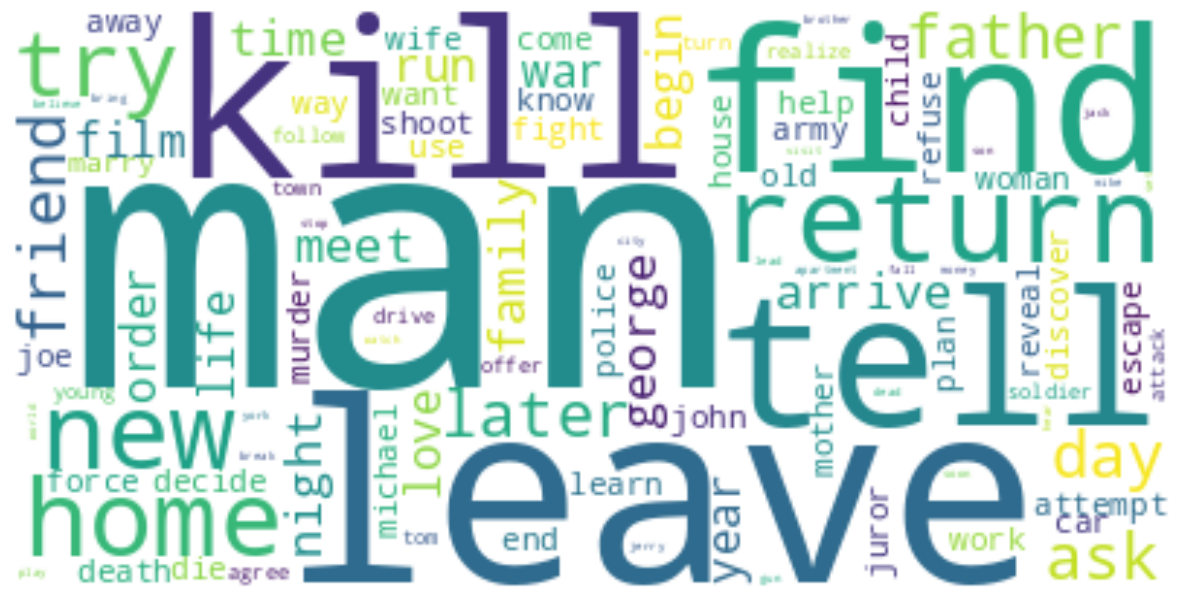

In [10]:
# Membuat wordcloud untuk memunculkan kata-kata yang paling sering muncul
#Makin sering muncul satu kata, makin besar hurufnya
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(movie_plot)).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
#Salah satu bagian penting untuk membuat search engine, kata-kata nya harus diletakan di "kamus"
#Untuk membuat kamus atau dictionary kita perlu gensim
from gensim import corpora

#creating term dictionary
%time dictionary = corpora.Dictionary(movie_plot)

#filter out terms which occurs in less than 4 documents and more than 20% of the documents.
#NOTE: Since we have smaller dataset, we will keep this commented for now.

#dictionary.filter_extremes(no_below=4, no_above=0.2)

#list of few which which can be further removed
stoplist = set('hello and if this can would should could tell ask stop come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

CPU times: user 70.3 ms, sys: 0 ns, total: 70.3 ms
Wall time: 71.7 ms


In [12]:
#print kamusnya
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)

[[['abrasive', 0], ['abroad', 1], ['abuse', 2], ['accept', 3], ['accuse', 4], ['act', 5], ['adams', 6], ['add', 7], ['address', 8], ['agree', 9], ['ambush', 10], ['angeles', 11], ['answer', 12], ['anthony', 13], ['apollonia', 14], ['arrange', 15], ['ask', 16], ['assassin', 17], ['assassination', 18], ['associate', 19], ['attack', 20], ['attempt', 21], ['authority', 22], ['aware', 23], ['baron', 24], ['barzini', 25], ['battle', 26], ['bed', 27], ['betrayal', 28], ['bodyguard', 29], ['bomb', 30], ['booth', 31], ['brasi', 32], ['brasis', 33], ['break', 34], ['bronx', 35], ['brother', 36], ['business', 37], ['buy', 38], ['capo', 39], ['capos', 40], ['captain', 41], ['car', 42], ['career', 43], ['carlo', 44], ['casino', 45], ['christening', 46], ['christmas', 47], ['clampdown', 48], ['clemenza', 49], ['collapse', 50]]]


In [13]:
#print kamusnya sekaligus menghitung berapa jumlah kata-kata tersebut muncul di dokumen nya
corpus = [dictionary.doc2bow(desc) for desc in movie_plot]

word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

print(word_frequencies)

[[('abrasive', 2), ('abroad', 2), ('abuse', 4), ('accept', 6), ('accuse', 2), ('act', 2), ('adams', 3), ('add', 2), ('address', 2), ('agree', 2), ('ambush', 2), ('angeles', 2), ('answer', 2), ('anthony', 3), ('apollonia', 2), ('arrange', 2), ('ask', 2), ('assassin', 4), ('assassination', 4), ('associate', 2), ('attack', 4), ('attempt', 4), ('authority', 2), ('aware', 2), ('baron', 2), ('barzini', 7), ('battle', 2), ('bed', 2), ('betrayal', 2), ('bodyguard', 2), ('bomb', 2), ('booth', 2), ('brasi', 3), ('brasis', 2), ('break', 2), ('bronx', 2), ('brother', 6), ('business', 6), ('buy', 2), ('capo', 1), ('capos', 2), ('captain', 2), ('car', 2), ('career', 2), ('carlo', 7), ('casino', 2), ('christening', 4), ('christmas', 2), ('clampdown', 2), ('clemenza', 3), ('collapse', 2), ('come', 4), ('command', 2), ('confess', 2), ('confront', 2), ('connection', 2), ('connie', 4), ('connies', 2), ('consigliere', 5), ('contact', 2), ('corleone', 10), ('corleones', 4), ('corps', 3), ('coveted', 2), ('

In [14]:
#Codingan2 dibawah adalah inti dari pembuatan search engine dengan metode TF-IDF
%time movie_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
%time movie_lsi_model = gensim.models.LsiModel(movie_tfidf_model[corpus], id2word=dictionary, num_topics=300)

CPU times: user 26.8 ms, sys: 50 µs, total: 26.9 ms
Wall time: 29.8 ms
CPU times: user 2.63 s, sys: 567 ms, total: 3.19 s
Wall time: 1.79 s


In [15]:
%time gensim.corpora.MmCorpus.serialize('movie_tfidf_model_mm', movie_tfidf_model[corpus])
%time gensim.corpora.MmCorpus.serialize('movie_lsi_model_mm',movie_lsi_model[movie_tfidf_model[corpus]])

CPU times: user 173 ms, sys: 1.94 ms, total: 175 ms
Wall time: 180 ms
CPU times: user 141 ms, sys: 937 µs, total: 142 ms
Wall time: 149 ms


In [16]:
#Load the indexed corpus
movie_tfidf_corpus = gensim.corpora.MmCorpus('movie_tfidf_model_mm')
movie_lsi_corpus = gensim.corpora.MmCorpus('movie_lsi_model_mm')

print(movie_tfidf_corpus)
print(movie_lsi_corpus)

MmCorpus(100 documents, 8402 features, 25989 non-zero entries)
MmCorpus(100 documents, 100 features, 10000 non-zero entries)


In [17]:
#Inti dari algoritmanya adalah mencari kata-kata yang mirip -> similar, index similarity nya tinggi
from gensim.similarities import MatrixSimilarity

%time movie_index = MatrixSimilarity(movie_lsi_corpus, num_features = movie_lsi_corpus.num_terms)

CPU times: user 19.1 ms, sys: 3.96 ms, total: 23 ms
Wall time: 29 ms


In [18]:
# Setelah kita bangun search engin nya. Codingan ini berfungsi untuk Query nya. Yaitu menampilkan judul movie yang cocok sesuai dengan Querynya
from operator import itemgetter

def search_similar_movies(search_term):

    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = movie_tfidf_model[query_bow]
    query_lsi = movie_lsi_model[query_tfidf]

    movie_index.num_best = 5

    movies_list = movie_index[query_lsi]

    movies_list.sort(key=itemgetter(1), reverse=True)
    movie_names = []

    for j, movie in enumerate(movies_list):

        movie_names.append (
            {
                'Relevance': round((movie[1] * 100),2),
                'Movie Title': df_movies['title'][movie[0]],
                'Movie Plot': df_movies['wiki_plot'][movie[0]]
            }

        )
        if j == (movie_index.num_best-1):
            break

    return pd.DataFrame(movie_names, columns=['Relevance','Movie Title','Movie Plot'])

In [19]:
# Saya ingin mencari filam terkait crime and drugs
search_similar_movies('crime and drugs ')

,Relevance,Movie Title,Movie Plot
0,81.88,Goodfellas,"Henry Hill (Liotta) admits, ""As far back as I ..."
1,33.94,The French Connection,"In Marseille, an undercover detective is follo..."
2,32.09,The Godfather,"On the day of his only daughter's wedding, Vit..."
3,28.86,A Clockwork Orange,"In futuristic London, Alex DeLarge is the lead..."
4,13.16,On the Waterfront,Mob-connected union boss Johnny Friendly (Lee ...


In [20]:
# search for movie dengan keyword violence protest march
search_similar_movies('violence protest march')

,Relevance,Movie Title,Movie Plot
0,74.08,Gandhi,The screenplay of Gandhi is available as a pub...
1,52.19,A Clockwork Orange,"In futuristic London, Alex DeLarge is the lead..."
2,27.03,Amadeus,The story begins in 1823 as the elderly Antoni...
3,24.64,All Quiet on the Western Front,\n\n\n\n\nThis section's plot summary may be t...
4,18.32,The Best Years of Our Lives,"After World War II, Fred Derry (Dana Andrews),..."


In [21]:
# search for movie tiles that are related to below search parameters
search_similar_movies('love affair hate')

,Relevance,Movie Title,Movie Plot
0,45.69,Terms of Endearment,Aurora Greenway (Shirley MacLaine) and her dau...
1,44.78,The Graduate,"Benjamin Braddock, going on from twenty to twe..."
2,30.33,From Here to Eternity,"In 1941, bugler and career soldier Private Rob..."
3,28.83,Out of Africa,"The story begins in 1913 in Denmark, when Kare..."
4,27.63,Wuthering Heights,A traveller named Lockwood (Miles Mander) is c...


In [22]:
search_similar_movies('politics')

,Relevance,Movie Title,Movie Plot
0,88.10,Mr. Smith Goes to Washington,"The governor of an unnamed western state, Hube..."
1,46.35,Doctor Zhivago,The film takes place mostly against a backdrop...
2,0.00,The Apartment,"Calvin Clifford (C. C.) ""Bud"" Baxter (Jack Lem..."
3,-0.00,The Philadelphia Story,\n \n Play media Play media Play media ...
4,-0.00,Dances with Wolves,"In 1863, First Lieutenant John J. Dunbar is wo..."


In [23]:
search_similar_movies('technology')

,Relevance,Movie Title,Movie Plot
0,99.7,Good Will Hunting,Twenty-year-old Will Hunting (Damon) of South ...
1,0.0,Dr. Strangelove or: How I Learned to Stop Worr...,United States Air Force Brigadier General Jack...
2,0.0,"The Good, the Bad and the Ugly",\n\n\nThis section needs an improved plot summ...
3,-0.0,American Graffiti,In late August 1962 recent high school graduat...
4,-0.0,A Clockwork Orange,"In futuristic London, Alex DeLarge is the lead..."


In [24]:
search_similar_movies('futuristic')

,Relevance,Movie Title,Movie Plot
0,99.8,A Clockwork Orange,"In futuristic London, Alex DeLarge is the lead..."
1,0.0,Terms of Endearment,Aurora Greenway (Shirley MacLaine) and her dau...
2,0.0,Forrest Gump,"While waiting at a bus stop in 1981, Forrest G..."
3,0.0,Vertigo,"ridge, Fort Point\n\n \n \n\n\n""Madeleine"" a..."
4,0.0,Patton,The film's beginning has General George S. Pat...


In [25]:
search_similar_movies('history')

,Relevance,Movie Title,Movie Plot
0,86.07,Gandhi,The screenplay of Gandhi is available as a pub...
1,35.24,Rocky,"On November 25, 1975, Rocky Balboa (Sylvester ..."
2,29.46,The Apartment,"Calvin Clifford (C. C.) ""Bud"" Baxter (Jack Lem..."
3,22.32,The Maltese Falcon,"\n\n\nIn 1539 the Knight Templars of Malta, pa..."
4,0.00,Wuthering Heights,A traveller named Lockwood (Miles Mander) is c...
